# Financial Analysis with Python

A primer

### Table of Contents
[Introduction](#Introduction)<br>
[Background](#Background)<br>
[Tools for Financial Analysis](#Tools)<br>
[Cash Flow Case Study](#Case-study:-Free-Cash-Flow-Projections-with-Monte-Carlo-Simulation)<br>
[Creating Financial Statements](#Creating-the-Financial-Statements)<br>
[DCF Valuation](#Performing-the-DCF-Valuation)<br>
[Data Export](#Exporting-the-Data)<br>
[Probability Distributions & Monte Carlo Simulation](#Creating-Probability-Distributions-for-Our-Monte-Carlo-Simulation)<br>
[Refactoring](#Refactoring)<br>
[Learning Resources](#Resources-for-Finance-Professionals-to-Learn-Python)<br>

## Introduction

Pandas with its DataFrame and Series objects, and Numpy with its ndarray are the workhorses of financial analysis with Python. Combined with matplotlib and other visualization libraries, you have great tools at your disposal to assist productivity.

This notebook is meant to demonstrate how to use Python with finance.

The example below shows the use of Monte Carlo simulations with a Discoutned Cash Flow (DCF) valuation model.

## Background

Some background before we get started.

[Discounted Cash Flow](https://www.youtube.com/watch?v=M8cuAJYYnTM) (DCF) analysis is a method of valuing a project, company, or asset using the concepts of the time value of money. Discounted cash flow analysis is widely used in investment finance, real estate development, corporate financial management and patent valuation.  Additional information of DCF models can be found [here](https://www.youtube.com/watch?v=L0e4tiZ-LA0) and [here](http://www.streetofwalls.com/finance-training-courses/investment-banking-technical-training/discounted-cash-flow-analysis/)

Expected value is the probability-weighted average of cash flows in all possible scenarios.

There are a few established ways of handling uncertainty in medium- or long-term projections.  One of those is using probability distributions and Monte Carlo simulations.  Using probability distributions allows modeling and visualizing the full range of possible outcomes in the forecast. Monte Carlo methods are subseqently utilized to calculate the resulting probability distributions.   This step permits analysis of how uncertain variables contribute to the overall uncertainty. 

## Tools

Here I use [Jupyter notebook](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).

You may also be interested in [the Python Quant Platform](https://home.tpq.io/pqp/).  Quant is a browser-based financial analytics and application development platform.

Jupyter is free to install.  I believe there is some cost to Quant.

## Case study: Free Cash Flow Projections with Monte Carlo Simulation

[Free Cash Flow](https://corporatefinanceinstitute.com/resources/knowledge/valuation/what-is-free-cash-flow-fcf/) Projections: a five-year cash flow forecast. These are projections of the amount of cash produced by a company’s business operations after paying for operating expenses and capital expenditures. Note there is no exact answer for deriving Free Cash Flow projections. The key is to be diligent when making the assumptions needed to derive these projections, and where uncertain, use valuation technique guidelines to  guide your thinking.  [Investopedia](https://www.investopedia.com/terms/f/freecashflow.asp) has additional information on free cash flow.

In this example, I set up and populate a basic cash flow model for valuation purposes, gradually replace the inputs with probability distributions, and finally run the simulation and analyze the results.

First, import the third-party packages we need for data manipulation and visualizations, and tell the program that we want to see charts inline in our notebook, instead of in separate windows:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Creating the Financial Statements
There are many ways that we can work with existing spreadsheet data in Python. We could, for example, read a sheet into a Pandas DataFrame with one line of code using the read_excel command. If you are not familiar with Pandas you can Google it or look at one of the [tutorials](https://github.com/jenniferp1/usg_tutorials) I developed.

Since this is a simple demonstration, we will be recreating it from scratch in our script vs. reading in an Excel spreadsheet. 

In [3]:
years = ['2018A', '2019B', '2020P', '2021P', '2022P', '2023P']
sales = pd.Series(index=years) 
sales

2018A   NaN
2019B   NaN
2020P   NaN
2021P   NaN
2022P   NaN
2023P   NaN
dtype: float64

Next, we declare a variable to represent the projected annual sales growth. Using this variable, we create a loop that calculates the sales in each year of the projections based on the previous year and the growth rate:

In [7]:
growth_rate = 0.1
sales[0] = 31.0
for year in range(1, 6):
    sales[year] = sales[year - 1] * (1 + growth_rate)
    
sales

2018A    31.00000
2019B    34.10000
2020P    37.51000
2021P    41.26100
2022P    45.38710
2023P    49.92581
dtype: float64

We now have projected sales above, instead of NaN

We continue, declaring variables we will need for the calculations to eventually arrive at free cash flow.

In [8]:
ebitda_margin = 0.14
depr_percent = 0.032

ebitda = sales * ebitda_margin
depreciation = sales * depr_percent
ebit = ebitda - depreciation

In [9]:
nwc_percent = 0.24

nwc = sales * nwc_percent
change_in_nwc = nwc.shift(1) - nwc 
capex_percent = depr_percent
capex = -(sales * capex_percent)

tax_rate = 0.25

tax_payment = -ebit * tax_rate
tax_payment = tax_payment.apply(lambda x: min(x, 0))

free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
free_cash_flow

2018A         NaN
2019B    2.018100
2020P    2.219910
2021P    2.441901
2022P    2.686091
2023P    2.954700
dtype: float64

The `tax_rate` variable above ensures that in scenarios where profit before tax becomes negative, we won’t have a positive tax payment. This shows how effectively you can apply custom functions to all cells in a Pandas Series or DataFrame. The actual function applied is, of course, a simplification. A more realistic model would have a separate tax model that calculates actual cash taxes paid based on a number of factors.

## Performing the DCF Valuation

We now calculate a simple terminal value and discount all cash flows back to the present to get the DCF result. 

In [10]:
cost_of_capital = 0.12
terminal_growth = 0.02
terminal_value = ((free_cash_flow[-1] * (1 + terminal_growth)) / 
                 (cost_of_capital - terminal_growth))
discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,6)]
dcf_value = (sum(free_cash_flow[1:] * discount_factors) +
            terminal_value * discount_factors[-1])
dcf_value

25.79438401113792

We now have a (rudimentary) DCF model in Python.

## Exporting the Data

Before moving on to the actual Monte Carlo simulation, let's exporting our results. If you have a Pandas DataFrame object, you can write that to an Excel file with one line using the to_excel method. 

In [12]:
dcf_model_output = pd.DataFrame([sales, ebit, free_cash_flow],
                     index=['Sales', 'EBIT', 'Free Cash Flow']).round(1)
dcf_model_output.to_excel('Python_DCF_Model_Output.xlsx')
dcf_model_output

,2018A,2019B,2020P,2021P,2022P,2023P
Sales,31.0,34.1,37.5,41.3,45.4,49.9
EBIT,3.3,3.7,4.1,4.5,4.9,5.4
Free Cash Flow,NaN,2.0,2.2,2.4,2.7,3.0


## Creating Probability Distributions for Our Monte Carlo Simulation

Next let's replace some of the point estimate inputs with probability distributions. 

Our first step is to decide how many iterations we want to run in the simulation. Using 1,000 as a starting point strikes a balance between getting enough data points to get sensible output plots, versus having the simulation finish within a sensible time frame. 

Next, we generate the actual distributions. Below we generate three normal distributions, but the NumPy library has a large number of distributions to choose from, and there are other places to look as well, including the Python standard library. After deciding which distribution to use, we need to specify the parameters required to describe their shape, such as mean and standard deviation, and the number of desired outcomes.

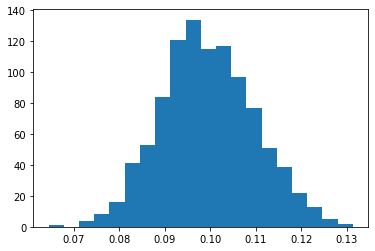

In [13]:
iterations = 1000
sales_growth_dist = np.random.normal(loc=0.1, scale=0.01, size=iterations)
ebitda_margin_dist = np.random.normal(loc=0.14, scale=0.02, size=iterations)
nwc_percent_dist = np.random.normal(loc=0.24, scale=0.01, size=iterations)
plt.hist(sales_growth_dist, bins=20)
plt.show()

Now we have everything we need to run the simulation, but they are not in a convenient format for running the simulation because they are broken up in different cell in the Notebook. Here is all the code we have worked with  in one cell and rearranged into a function for convenience:

In [15]:
def run_mcs():
    
    # Create probability distributions
    sales_growth_dist = np.random.normal(loc=0.1, scale=0.01, size=iterations)
    ebitda_margin_dist = np.random.normal(loc=0.14, scale=0.02, size=iterations)
    nwc_percent_dist = np.random.normal(loc=0.24, scale=0.01, size=iterations)
    
    # Calculate DCF value for each set of random inputs
    output_distribution = []
    for i in range(iterations):
        for year in range(1, 6):
            sales[year] = sales[year - 1] * (1 + sales_growth_dist[0])
        ebitda = sales * ebitda_margin_dist[i]
        depreciation = (sales * depr_percent)
        ebit = ebitda - depreciation
        nwc = sales * nwc_percent_dist[i]
        change_in_nwc = nwc.shift(1) - nwc 
        capex = -(sales * capex_percent)
        tax_payment = -ebit * tax_rate
        tax_payment = tax_payment.apply(lambda x: min(x, 0))
        free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
        
    # DCF valuation
        terminal_value = (free_cash_flow[-1] * 1.02) / (cost_of_capital - 0.02)
        free_cash_flow[-1] += terminal_value
        discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,6)]
        dcf_value = sum(free_cash_flow[1:] * discount_factors )
        output_distribution.append(dcf_value)
    
    return output_distribution

We can now run the whole simulation and plot the output distribution, which will be the discounted cash flow value  in each of the 1,000 iterations. The `%time` command is not Python code but a notebook shorthand that measures the time to run something. It depends on the computer you run it on, so your times may differ.

CPU times: user 1.77 s, sys: 0 ns, total: 1.77 s
Wall time: 1.7 s


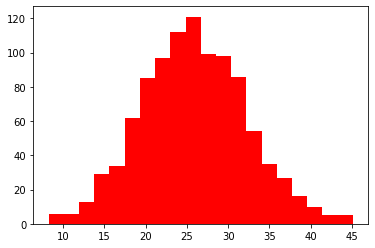

In [16]:
%time plt.hist(run_mcs(), bins=20, color='r')
plt.show()

## Refactoring

Refactoring refers to the process of rewriting existing code to improve its structure without changing its functionality. There can be several reasons to do this:
<ol>
<li>Organize the different parts in a more sensible way.</li>
<li>Rename variables and functions to make their purpose and workings clearer.</li>
<li>Allow and prepare for future features.</li>
<li>Improve the execution speed, memory footprint or other resource utilization.</li>
</ol>
As an example, we clean things up below by collecting all initial variables in one place, rather than scattered throughout as in the prototype script


In [17]:
# Key inputs from DCF model
years = 5
starting_sales = 31.0
capex_percent = depr_percent = 0.032
sales_growth = 0.1
ebitda_margin = 0.14
nwc_percent = 0.24
tax_rate = 0.25

# DCF assumptions
r = 0.12
g = 0.02

# For MCS model
iterations = 1000
sales_std_dev = 0.01
ebitda_std_dev = 0.02
nwc_std_dev = 0.01

In [19]:
def run_mcs():
    
    # Generate probability distributions
    sales_growth_dist = np.random.normal(loc=sales_growth, 
                                         scale=sales_std_dev, 
                                         size=(years, iterations))
    ebitda_margin_dist = np.random.normal(loc=ebitda_margin, 
                                          scale=ebitda_std_dev, 
                                          size=(years, iterations))
    nwc_percent_dist = np.random.normal(loc=nwc_percent, 
                                        scale=nwc_std_dev, 
                                        size=(years, iterations))
    
    # Calculate free cash flow
    sales_growth_dist += 1
    for i in range(1, len(sales_growth_dist)):
        sales_growth_dist[i] *= sales_growth_dist[i-1]
        
    sales = sales_growth_dist * starting_sales
    ebitda = sales * ebitda_margin_dist
    ebit = ebitda - (sales * depr_percent)
    tax = -(ebit * tax_rate)
    np.clip(tax, a_min=None, a_max=0)
    nwc = nwc_percent_dist * sales
    starting_nwc = starting_sales * nwc_percent
    prev_year_nwc = np.roll(nwc, 1, axis=0)
    prev_year_nwc[0] = starting_nwc
    delta_nwc = prev_year_nwc - nwc
    capex = -(sales * capex_percent)
    free_cash_flow = ebitda + tax + delta_nwc + capex
    
    # Discount cash flows to get DCF value
    terminal_value = free_cash_flow[-1] * (1 + g) / (r - g)
    discount_rates = [(1 / (1 + r)) ** i for i in range (1,6)]
    dcf_value = sum((free_cash_flow.T * discount_rates).T) 
    dcf_value += terminal_value * discount_rates[-1]
        
    return dcf_value

CPU times: user 24.8 ms, sys: 0 ns, total: 24.8 ms
Wall time: 23.6 ms


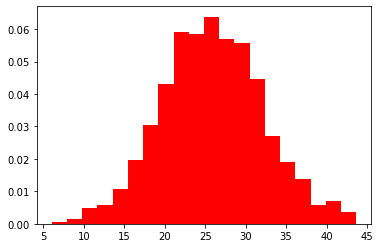

In [20]:
%time plt.hist(run_mcs(), bins=20, density=True, color="r")
plt.show()

You can see that we reduced the runtime by refactoring.

That's it for now.

## Resources for Finance Professionals to Learn Python
Books:

* [Python for Finance](https://www.goodreads.com/book/show/22221113-python-for-finance) by Yves Hilpisch<br>
* [Learning Python](https://www.goodreads.com/book/show/80435.Learning_Python?ac=1&from_search=true) by Mark Lutz<br>
* [Fluent Python](https://www.goodreads.com/book/show/22800567-fluent-python?ac=1&from_search=true) by Luciano Ramalho<br>


[The Python Quants](https://home.tpq.io/)